# Preprocessing

In [584]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


# reading
data = pd.read_csv('dodgers_onbase.csv')

data.head()

,out,batter,name,they,us,b1,b2,b3,call,thisatbat,p4count,balls,strikes,inthezone,t_b,inning
0,1,Yangervis Solarte,Kershaw,0,0,0,1,0,B,1,B,0.0,0.0,0,t,1
1,1,Yangervis Solarte,Kershaw,0,0,0,0,1,B,1,B,0.0,0.0,0,t,1
2,1,Yangervis Solarte,Kershaw,0,0,0,0,1,B,2,BB,1.0,0.0,0,t,1
3,1,Yangervis Solarte,Kershaw,0,0,0,0,1,F,3,BBF,2.0,0.0,0,t,1
4,1,Yangervis Solarte,Kershaw,0,0,0,0,1,F,4,BBFF,2.0,1.0,0,t,1


In [585]:
data2 = data.drop(columns=['call', 'p4count', 'batter', 'name', 't_b'])

In [586]:
data2.head()

,out,they,us,b1,b2,b3,thisatbat,balls,strikes,inthezone,inning
0,1,0,0,0,1,0,1,0.0,0.0,0,1
1,1,0,0,0,0,1,1,0.0,0.0,0,1
2,1,0,0,0,0,1,2,1.0,0.0,0,1
3,1,0,0,0,0,1,3,2.0,0.0,0,1
4,1,0,0,0,0,1,4,2.0,1.0,0,1


In [587]:
data2['thisatbat'] = data2.thisatbat/4

In [588]:
data2['balls'] = data2.balls/3

In [589]:
data2['strikes'] = data2.strikes/2

In [590]:
data2['inning'] = data2.inning/7

In [591]:
data2['out'] = data2.out/2

In [592]:
data2['winning'] = data2.us > data2.they

In [593]:
data2.head()

,out,they,us,b1,b2,b3,thisatbat,balls,strikes,inthezone,inning,winning
0,0.5,0,0,0,1,0,0.25,0.000000,0.0,0,0.142857,False
1,0.5,0,0,0,0,1,0.25,0.000000,0.0,0,0.142857,False
2,0.5,0,0,0,0,1,0.50,0.333333,0.0,0,0.142857,False
3,0.5,0,0,0,0,1,0.75,0.666667,0.0,0,0.142857,False
4,0.5,0,0,0,0,1,1.00,0.666667,0.5,0,0.142857,False


In [594]:
data2["winning"].replace({True:1, False:0}, inplace=True)

In [595]:
data2.drop(columns=['they','us'], inplace=True)

In [596]:
data2.head()

,out,b1,b2,b3,thisatbat,balls,strikes,inthezone,inning,winning
0,0.5,0,1,0,0.25,0.000000,0.0,0,0.142857,0
1,0.5,0,0,1,0.25,0.000000,0.0,0,0.142857,0
2,0.5,0,0,1,0.50,0.333333,0.0,0,0.142857,0
3,0.5,0,0,1,0.75,0.666667,0.0,0,0.142857,0
4,0.5,0,0,1,1.00,0.666667,0.5,0,0.142857,0


In [597]:

# X and y creation
X = data2
y = X.pop("inthezone")

# Feature Engineering
#X.loc[:, "Cabin"] = X.Cabin.str[0]

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

# building the pipeline
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))
 
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categoric_pipe, X_cat.columns),
    ]
)

full_pipeline = make_pipeline(preprocessor, 
                              DecisionTreeClassifier())

# Modelling

In [598]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean"],
    "decisiontreeclassifier__max_depth": range(1,10),
    "decisiontreeclassifier__min_samples_leaf": range(1,20)
}


search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search.fit(X_train, y_train)

search.best_score_

Fitting 5 folds for each of 171 candidates, totalling 855 fits


0.5494051346274265

In [599]:
search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'decisiontreeclassifier__max_depth': 2,
 'decisiontreeclassifier__min_samples_leaf': 1}

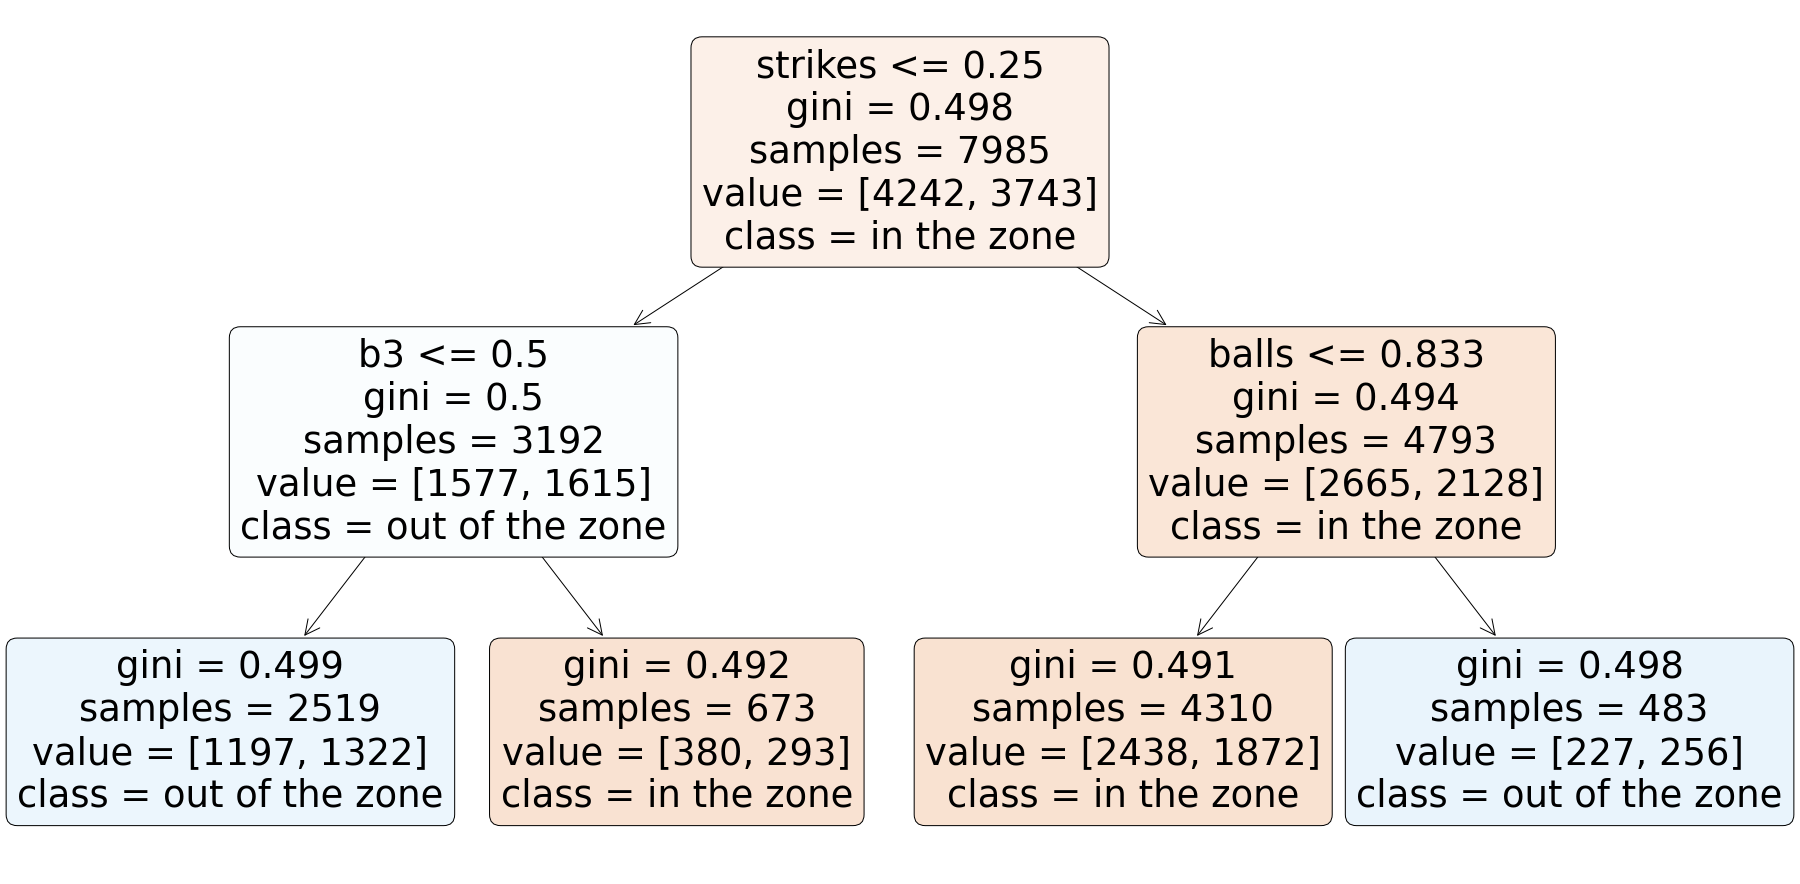

In [600]:
cat_cols = X_num.columns.tolist()
cat_cols.extend(search.best_estimator_.named_steps['columntransformer'].transformers[1][1].named_steps['onehotencoder'].fit(X_cat).get_feature_names(X_cat.columns))

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(32, 16))
plot_tree(
    search.best_estimator_.named_steps['decisiontreeclassifier'],
    filled=True, 
    rounded=True, 
    class_names=['in the zone','out of the zone'], 
    feature_names=cat_cols
    );

# Error analysis

In [601]:
accuracy_score(search.predict(X_test), y_test)

0.5472972972972973

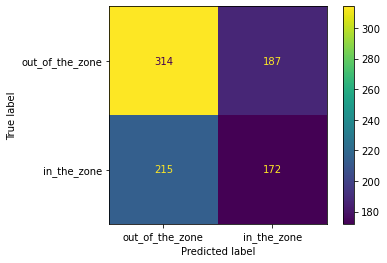

In [602]:
from sklearn.metrics import plot_confusion_matrix ## for sklearn older than  1.0 version
plot_confusion_matrix(search, X_test, y_test, display_labels=['out_of_the_zone', 'in_the_zone']);

# the following is applicable to sklearn 1.0 and above
# from sklearn.metrics import ConfusionMatrixDisplay
# ConfusionMatrixDisplay.from_estimator(search, 
#                                       X_test, 
#                                       y_test, 
#                                       display_labels=['Not Survied', 'Survived']);

## KNN

In [396]:
## Challenge: build the same pipeline using a KNN instead of a decision tree.
## Tip: create a new pipeline with the "preprocessor" and a KNN Classifier